In [1]:
import sys
import os
import os.path
from tqdm import tqdm
from PIL import Image 
import random
from utils.helper_functions import get_file_num
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
curPath = os.path.abspath(os.path.dirname("sequential_model.py"))
print(curPath)
rootPath = os.path.split(curPath)[0]
print(rootPath)
sys.path.append(rootPath)
sys.path.append(curPath)

/vol/bitbucket/ql1220/IndividualProject/poseestimate/core
/vol/bitbucket/ql1220/IndividualProject/poseestimate


In [2]:
root='/vol/biodata/data/h36m_processed/training/'
actors=['S%d' % i for i in [1]]
activities=['posing']
pose_root='/vol/biodata/data/h36m_poses/d2'

In [6]:
data_sequences = []
for actor in tqdm(actors): # actor is in the form of 'S1','S5'
    sequences = os.listdir(os.path.join(root, actor))
    for activity in activities:
        activity_sequences = [s for s in sequences if s.lower().startswith(activity.lower())]
        for seq in activity_sequences:
            bboxs=os.listdir(os.path.join(root, actor,seq))
            for bbox in bboxs:
                frames = os.listdir(os.path.join(root, actor,seq, bbox))
                frames = [int(x[5:-4]) for x in frames] # like 'frame0001', take last 4 number
                frames = sorted(frames) # sorted int value  
                if len(frames)>1:
                    pose_path=os.path.join(pose_root,actor,seq)
                    if not os.path.isdir(pose_path):
                        continue
                    pose_num=get_file_num(os.path.join(pose_root, actor,seq))
                    if pose_num<1:
                        continue
                    for frame1_num in frames:
                        frame2_num=random.sample(frames, 1)[0]
                        data_sequences.append({ 'actor': actor, # str
                                           'activity_sequence': seq, # str
                                           'bbox': bbox,
                                           'frame1': frame1_num, # list of int
                                           'frame2': frame2_num, # int
                                              })
                
        

100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


In [7]:
hip = 'hip'
r_hip = 'r_hip'
r_knee = 'r_knee'
r_ankle = 'r_ankle'
r_ball = 'r_ball'
l_hip = 'l_hip'
l_knee = 'l_knee'
l_ankle = 'l_ankle'
l_ball = 'l_ball'
l_shoulder = 'l_shoulder'
l_elbow = 'l_elbow'
l_wrist = 'l_wrist'
l_thumb = 'l_thumb'
r_shoulder = 'r_shoulder'
r_elbow = 'r_elbow'
r_wrist = 'r_wrist'
r_thumb = 'r_thumb'
l_little = 'l_little'
r_little = 'r_little'

joint_indices = {
    l_hip: 6,
    r_hip: 1,
    l_shoulder: 17,
    r_shoulder: 25,
    l_knee: 7,
    r_knee: 2,
    l_elbow: 18, 
    r_elbow: 26,
    l_ankle: 8,
    r_ankle: 3,
    l_wrist: 19,
    r_wrist: 27,
    l_ball: 9,
    r_ball: 4,    
    l_little: 22,
    r_little: 30
}
joints=[]
for _,v in joint_indices.items():
    joints.append(v)

In [49]:
s=data_sequences[0]
frame2_path = os.path.join(root,s['actor'],s['activity_sequence'],s['bbox'],'frame{:0>4d}'.format(s['frame1'])+'.png')
frame2 = Image.open(frame2_path)

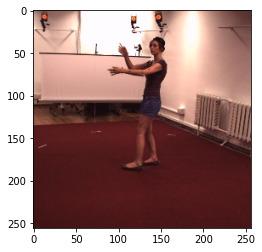

In [52]:
plt.imshow(frame2)

In [8]:
def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)

def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale])
    scale_tmp = scale * 200.0
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]
    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)
    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir
    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])
    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
    return trans

In [9]:
def get_bbx(string):
    bbx = np.asarray([int(float(s)) * 200 for s in string.split(',')]).reshape((2, 2))
    return bbx
def get_center_scale(bbx):
    center = (bbx[0, 0] + (bbx[1, 0] - bbx[0, 0])/2, bbx[0, 1] + (bbx[1, 1] - bbx[0, 1])/2)
    center = np.array(center)
    scale = ((bbx[1, 1] - bbx[0, 1])/200)
    return center,scale

In [10]:
def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

array([[200, 200],
       [800, 800]])

In [14]:
def get_frame2(sequence):
    frame2_num=sequence['frame2']
    sequence_path=os.path.join(root, sequence['actor'], sequence['activity_sequence'],sequence['bbox'])
    frame2_path = os.path.join(sequence_path,'frame{:0>4d}'.format(frame2_num)+'.png')
    frame2 = Image.open(frame2_path)
    frame2_size= np.array(frame2).shape #(H,W,C)
    print(frame2_size)
    frame2_torch=trans(frame2) 
    return frame2_torch

def get_pose2D(sequence):  
    pose_folder = os.path.join(pose_root, sequence['actor'], sequence['activity_sequence'])
    pose_name='/2d_pose_'
    pose=np.load(pose_folder+pose_name+str(sequence['frame1']-1)+'.npy')
    print(pose.shape)
    pose=pose[joints,:]
    bbx=get_bbx(sequence['bbox'])
    center,scale=get_center_scale(bbx)
    trans = get_affine_transform(center, scale, 0,(256,256))
    for i in range(len(pose)):
        pose[i] = affine_transform(pose[i], trans)
    pose_tensor=torch.FloatTensor(pose)
    return pose_tensor

In [12]:
def get_single(sequence):
    sequence_path=os.path.join(root, sequence['actor'], sequence['activity_sequence'],sequence['bbox'])
    frame_path=os.path.join(sequence_path,'frame{:0>4d}'.format( sequence['frame1'])+'.png')
    img = Image.open(frame_path)
    frame_tensor=trans(img) #(CHW)
    frame2_torch= get_frame2(sequence)
    pose2D=get_pose2D(sequence)

    return (frame_tensor,frame2_torch,pose2D)

In [15]:
import torchvision.transforms as transforms
trans=transforms.ToTensor()
frame2=get_frame2(data_sequences[100])
print(frame2.shape)
pose=get_pose2D(data_sequences[100])
print(pose.size())

(256, 256, 3)
torch.Size([3, 256, 256])
(32, 2)
torch.Size([16, 2])


In [18]:
frame,frame2,pose=get_single(data_sequences[300])

(256, 256, 3)
(32, 2)


In [93]:
print(frame.size(),frame2.size(),pose.size())

torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([16, 2])


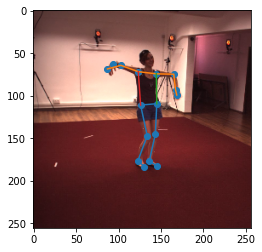

In [19]:
indices1 = np.asarray([12, 8, 4, 0, 1, 5, 9, 13])
indices2 = np.asarray([15, 7, 3, 2, 6, 10, 14])
indices3 = np.asarray([0, 2])
indices4 = np.asarray([1, 3])
pose1=pose[indices1]
pose2=pose[indices2]
pose3=pose[indices3]
pose4=pose[indices4]
plt.imshow(frame.permute(1,2,0).numpy())
plt.plot(pose1[:,0],pose1[:,1])
plt.plot(pose2[:,0],pose2[:,1])
plt.plot(pose3[:,0],pose3[:,1])
plt.plot(pose4[:,0],pose4[:,1])
plt.scatter(pose[:,0],pose[:,1])

In [55]:
 def get_single(sequence):
        sequence_paths=os.path.join(self.root, sequence['actor'], 'frames', sequence['activity_sequence'])
        frames=[]
        frame_path=os.path.join(sequence_paths,'frame{:0>4d}'.format( sequence['frame1'])+'.png')
        img = Image.open(frame_path)
        frame_tensor=self.transforms(img) #(CHW)
        frame2_torch,frame2_size= get_frame2(sequence)
        pose2D=get_pose2D(sequence)
        
        return (frame_tensor,frame2_torch,pose2D)

In [2]:
import utils.datasets_processed as ds
from torch.utils.data import DataLoader

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
actors=['S%d' % i for i in [1]]
activities=['directions']
# activities = ['directions', 'discussion','eating','purchases', 'greeting', 'posing',
#                       'waiting', 'walking','walktogether','sitting','smoking','photo']
# actors = ['S%d' % i for i in [1, 5, 6, 7, 8]]
# activities = ['directions', 'discussion','eating','purchases', 'greeting','phoning', 'posing','purchases',
#                       'waiting', 'walking','walktogether','sitting','walkdog','sittingdown','smoking','photo']
# actors = ['S%d' % i for i in [1, 5, 6, 7, 8]]
root='/vol/biodata/data/h36m_processed/training/'
pose_root='/vol/biodata/data/h36m_poses/d2/'
pose3d_root='/vol/biodata/data/h36m_poses/d3/'
data=ds.Human36M(root,pose_root,activities,actors)
pose_data=ds.Human36MPose(pose3d_root,data.get_sequences())

100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


In [5]:
print(len(data.sequences))

5458


In [ ]:
loader=DataLoader(data, 50, shuffle=True, drop_last=True, num_workers=8)
for batch in loader:
    frame1, frame2, preds2d = batch
    if frame1.shape !=(50,3,256,256):
        print('error')
        break

In [7]:
from torch.utils.data import DataLoader
loader=DataLoader(data, 35,shuffle=True, drop_last=True, num_workers=8)

In [7]:
frame,frame2,pose=data.get_single(data.sequences[2400])

(256, 256, 3)


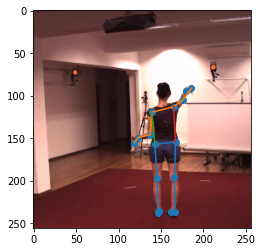

In [8]:
indices1 = np.asarray([12, 8, 4, 0, 1, 5, 9, 13])
indices2 = np.asarray([15, 7, 3, 2, 6, 10, 14])
indices3 = np.asarray([0, 2])
indices4 = np.asarray([1, 3])
pose1=pose[indices1]
pose2=pose[indices2]
pose3=pose[indices3]
pose4=pose[indices4]
plt.imshow(frame.permute(1,2,0))
plt.plot(pose1[:,0],pose1[:,1])
plt.plot(pose2[:,0],pose2[:,1])
plt.plot(pose3[:,0],pose3[:,1])
plt.plot(pose4[:,0],pose4[:,1])
plt.scatter(pose[:,0],pose[:,1])

In [6]:
if not os.path.exists('1transforms.py'):
    print('yes')

yes


In [5]:
import trainer

/vol/bitbucket/ql1220/envs/pose_env/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


In [6]:
logdir='/vol/bitbucket/ql1220/out/log_test'
checkdir='/vol/bitbucket/ql1220/out/check_test'
# model.load_checkpoint(checkdir+'/checkpoint_0.tar')
model=trainer.ForwardKinematics(data,pose_data)
torch.cuda.empty_cache()

/vol/bitbucket/ql1220/envs/pose_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4658 800 5458
4658 800 5458


In [7]:
model.train(35,5,logdir,checkdir)

/vol/bitbucket/ql1220/envs/pose_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


epoch: 0
val_loss: 0.31500010514970533 loss2d 0.011009594044563446 recon_loss 0.008818614677610722 adv_loss 0.9804277501323007
epoch: 1
250
val_loss: 0.2542750146578659 loss2d 0.006461406063119119 recon_loss 0.007193362805992365 adv_loss 0.9123379561034116
epoch: 2
val_loss: 0.242354942468757 loss2d 0.004784798260185529 recon_loss 0.006572668504139239 adv_loss 0.9396714568138123
epoch: 3
500
val_loss: 0.23148093326440589 loss2d 0.0041016864336349745 recon_loss 0.00588774340311912 adv_loss 0.9228816276246851
epoch: 4
val_loss: 0.22167462973262778 loss2d 0.0031876619799401274 recon_loss 0.005589117782867767 adv_loss 0.9210444607517936
Training finished
